In [42]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline



In [43]:
#load DF
#https://www.census.gov/econ/bfs/data/county.html
df1 = pd.read_excel(r"bfs_county_apps_annual.xlsx")

In [44]:
#gather info of DF
print(df1.head())

  State          County  County Code  state_fips  county_fips BA2005 BA2006  \
0    AL  Autauga County         1001           1            1    335    348   
1    AL  Baldwin County         1003           1            3   1986   2101   
2    AL  Barbour County         1005           1            5    138    179   
3    AL     Bibb County         1007           1            7    118    145   
4    AL   Blount County         1009           1            9    315    323   

  BA2007 BA2008 BA2009  ... BA2015 BA2016 BA2017 BA2018 BA2019 BA2020 BA2021  \
0    348    367    288  ...    291    294    313    384    394    559    776   
1   1975   1721   1505  ...   1735   1858   2114   2104   2317   2697   3407   
2    156    139    133  ...    129    122    114    113    135    230    334   
3    117     98     98  ...     78     86     79    105     86    165    199   
4    297    306    247  ...    218    254    281    299    312    344    473   

  BA2022 BA2023 BA2024  
0    703    722    

In [45]:
#gather info for DF
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3156 entries, 0 to 3155
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   State        3156 non-null   object
 1   County       3156 non-null   object
 2   County Code  3156 non-null   int64 
 3   state_fips   3156 non-null   int64 
 4   county_fips  3156 non-null   int64 
 5   BA2005       3156 non-null   object
 6   BA2006       3156 non-null   object
 7   BA2007       3156 non-null   object
 8   BA2008       3156 non-null   object
 9   BA2009       3156 non-null   object
 10  BA2010       3156 non-null   object
 11  BA2011       3156 non-null   object
 12  BA2012       3156 non-null   object
 13  BA2013       3156 non-null   object
 14  BA2014       3156 non-null   object
 15  BA2015       3156 non-null   object
 16  BA2016       3156 non-null   object
 17  BA2017       3156 non-null   object
 18  BA2018       3156 non-null   object
 19  BA2019       3156 non-null 

In [46]:
#convert categorical columns
df1['State'] = df1['State'].astype('category')
df1['County'] = df1['County'].astype('category')
df1.rename(columns=lambda x: x.replace('BA', '') if x.startswith('BA') else x, inplace=True)



In [49]:
#identify year columns (now just numbers)
year_cols = [c for c in df1.columns if isinstance(c, str) and c.isdigit()]
year_cols = sorted(year_cols, key=int)
for col in year_cols:
    df1[col] = pd.to_numeric(df1[col], errors='coerce')

The code first cleans and formats the data so it’s easier to work with. It converts the State and County columns into categorical types, which saves memory and makes grouping faster. It also renames columns so that ones like “BA2019” just read “2019,” which helps later when identifying the year columns.

In [50]:
#group by State and calculate mean for numeric columns only
state_trends = df1.groupby('State')[year_cols].mean()
#Transpose for plotting
state_trends = state_trends.T


C:\Users\carson.rodriguez\AppData\Local\Temp\ipykernel_8876\2844134152.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_trends = df1.groupby('State')[year_cols].mean()


The code groups everything by state, taking the average of all counties in that state for each year. Then it flips the table so each column is a state and each row is a year, and plots lines showing the average number of business applications per state over time. This gives a good visual sense of which states are trending up or down.

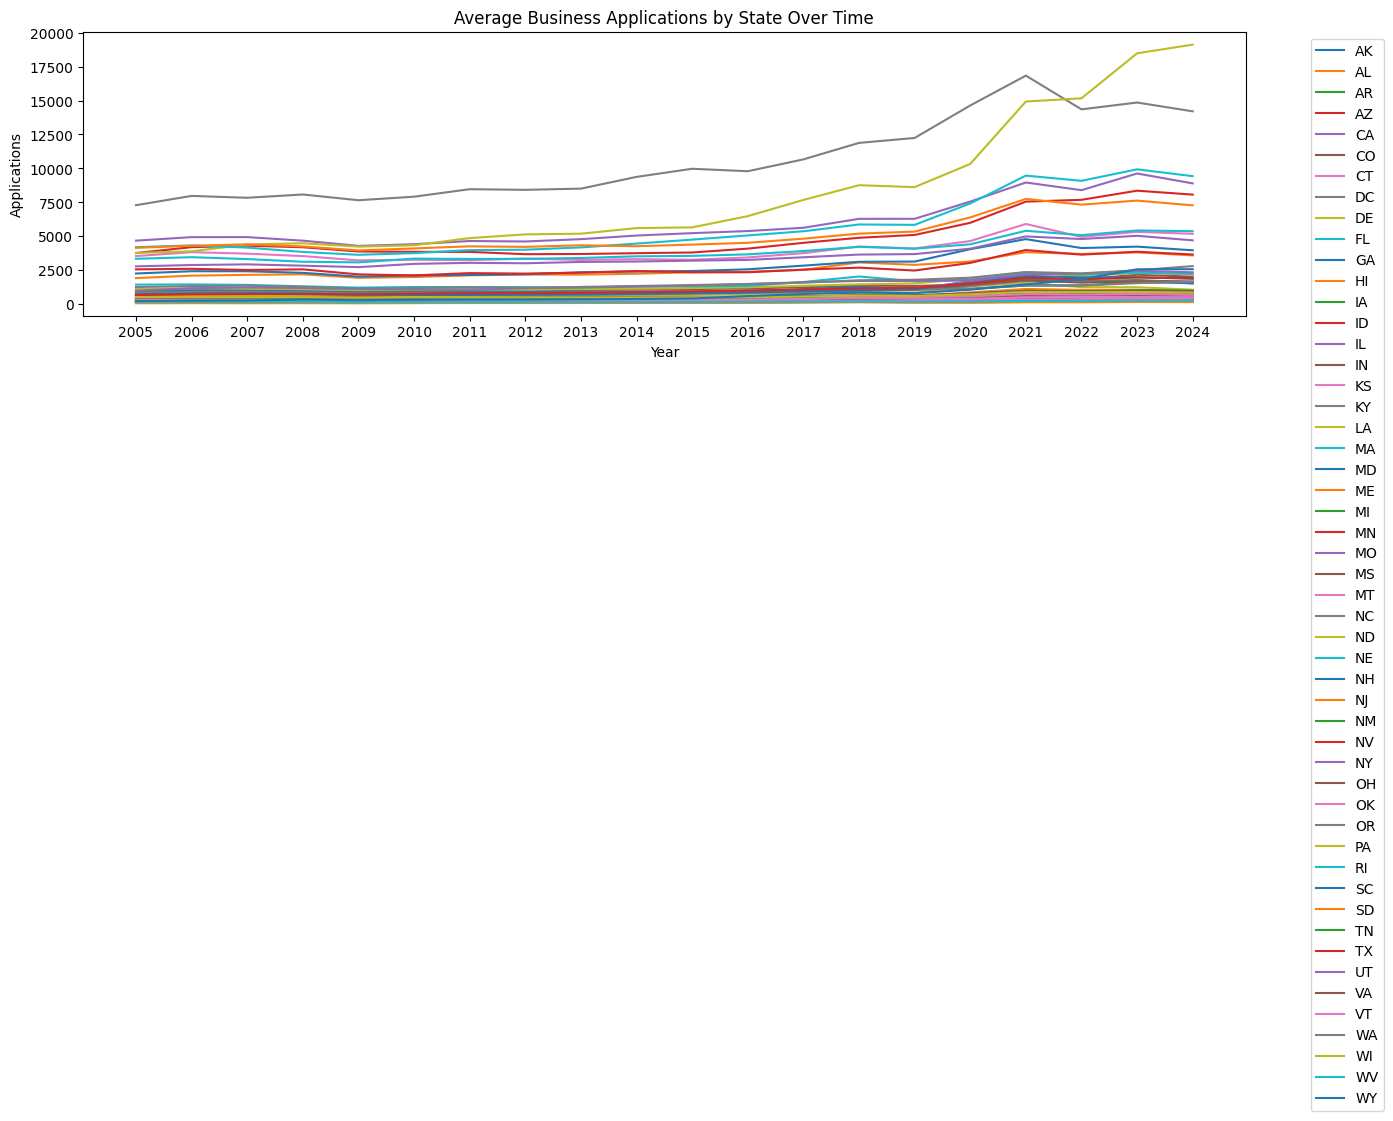

In [51]:
plt.figure(figsize=(14, 8))
for state in state_trends.columns:
    plt.plot(state_trends.index, state_trends[state], label=state)
plt.title('Average Business Applications by State Over Time')
plt.xlabel('Year')
plt.ylabel('Applications')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
#mapping of regions
regions = {
    'Northeast': ['NY', 'PA', 'MA', 'NJ'],
    'Midwest': ['IL', 'OH', 'MI', 'WI'],
    'South': ['TX', 'FL', 'GA', 'NC'],
    'West': ['CA', 'WA', 'OR', 'NV']
}

# Compute regional averages
region_trends = pd.DataFrame(index=year_cols)
for region, states in regions.items():
    region_trends[region] = df1[df1['State'].isin(states)][year_cols].mean()


Calculates the regional averages for each year and plots another line chart showing how different parts of the country compare.

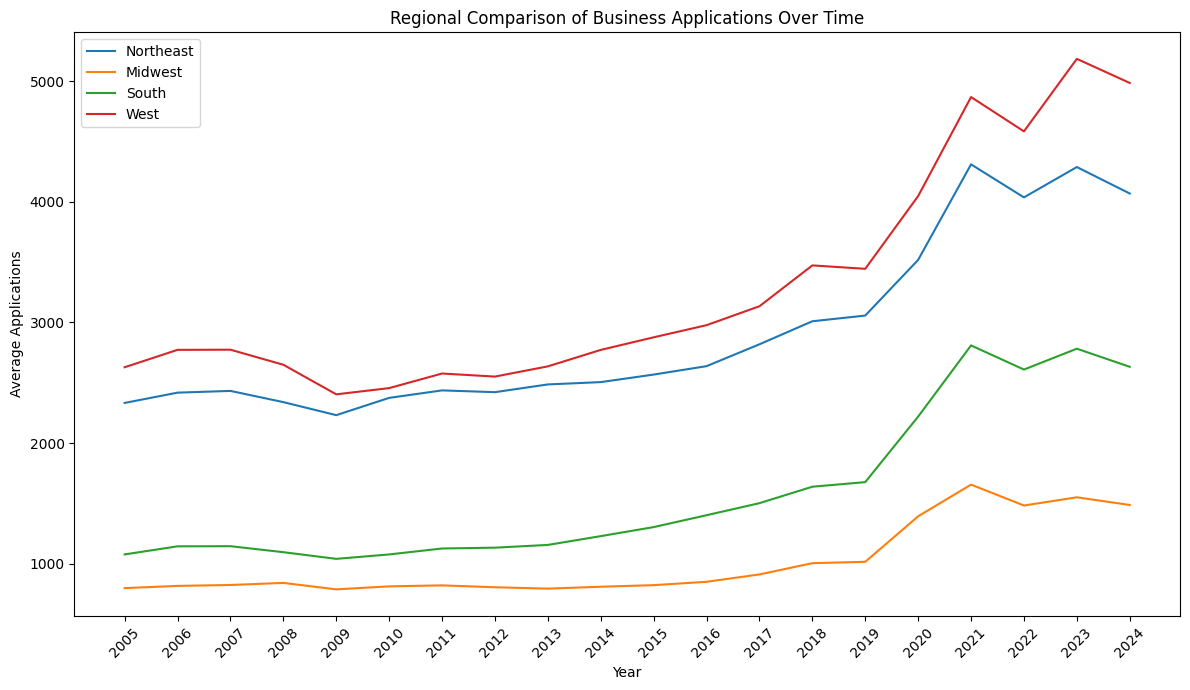

In [53]:
plt.figure(figsize=(12, 7))
for region in region_trends.columns:
    plt.plot(region_trends.index, region_trends[region], label=region)
plt.title('Regional Comparison of Business Applications Over Time')
plt.xlabel('Year')
plt.ylabel('Average Applications')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


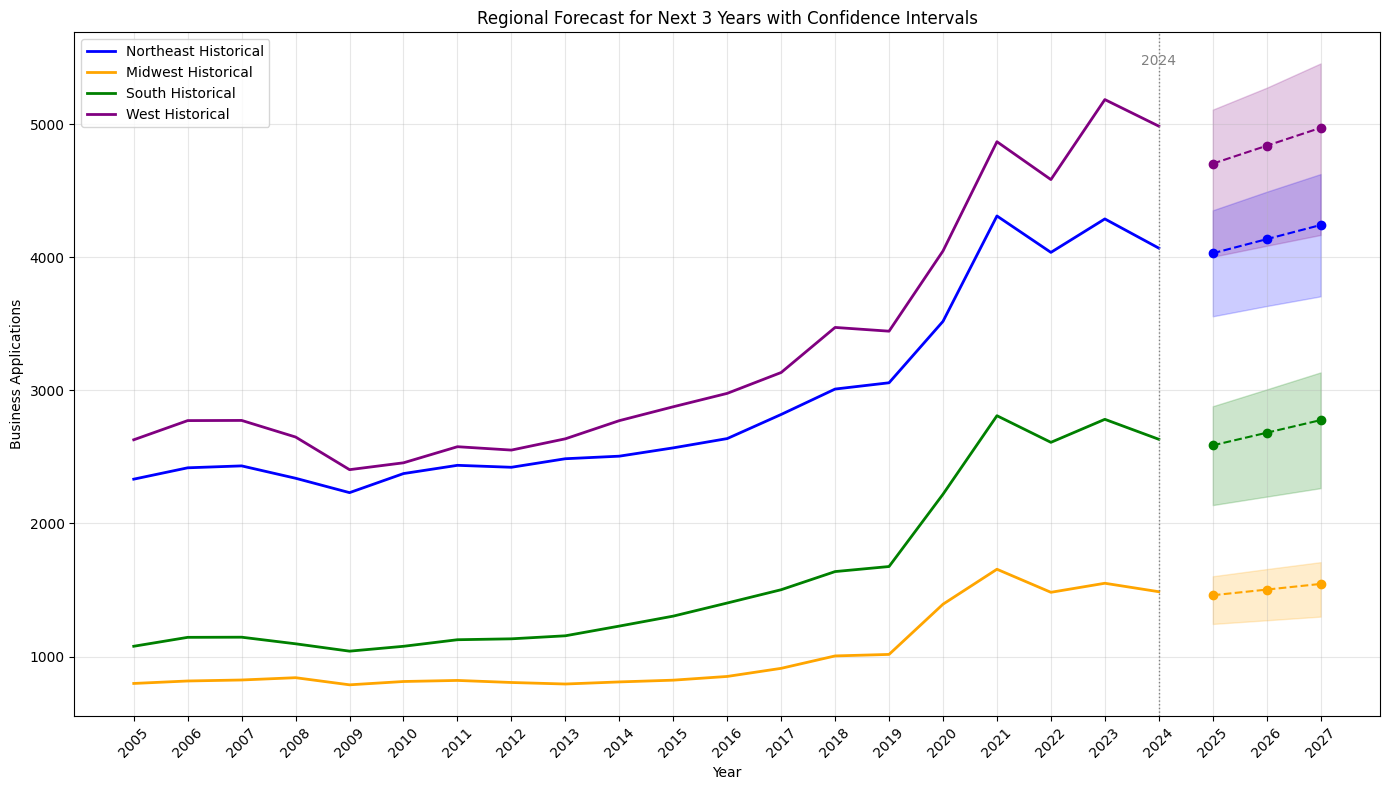

In [54]:
future_years = ['2025', '2026', '2027']
colors = {'Northeast': 'blue', 'Midwest': 'orange', 'South': 'green', 'West': 'purple'}

def prediction_interval(model, X_future, X_train, y_train, n_bootstrap=500, alpha=0.05):
    preds = []
    for _ in range(n_bootstrap):
        sample_idx = np.random.choice(len(X_train), len(X_train), replace=True)
        X_sample = X_train[sample_idx]
        y_sample = y_train[sample_idx]
        model.fit(X_sample, y_sample)
        preds.append(model.predict(X_future))
    preds = np.array(preds)
    lower = np.percentile(preds, 100 * alpha / 2, axis=0)
    upper = np.percentile(preds, 100 * (1 - alpha / 2), axis=0)
    return lower, upper

plt.figure(figsize=(14, 8))
for region, states_list in regions.items():
    region_data = df1[df1['State'].isin(states_list)][year_cols].mean()
    X_reg = np.array([int(year) for year in year_cols]).reshape(-1, 1)
    y_reg = region_data.values

    model = LinearRegression()
    model.fit(X_reg, y_reg)

    X_future = np.array([int(year) for year in future_years]).reshape(-1, 1)
    predictions = model.predict(X_future)
    lower_ci, upper_ci = prediction_interval(model, X_future, X_reg, y_reg)

    #plot historical data
    plt.plot(year_cols, y_reg, label=f'{region} Historical', color=colors[region], linewidth=2)
    #forecast
    plt.plot(future_years, predictions, marker='o', color=colors[region], linestyle='--')
    #confidence interval shading
    plt.fill_between(future_years, lower_ci, upper_ci, color=colors[region], alpha=0.2)

plt.axvline(x='2024', color='gray', linestyle=':', linewidth=1)
plt.text('2024', max(y_reg)*1.05, '2024', color='gray', ha='center')

plt.title('Regional Forecast for Next 3 Years with Confidence Intervals')
plt.xlabel('Year')
plt.ylabel('Business Applications')
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The graph shows that new business activity has been increasing across the United States with the West and Northeast leading. The South has been growing rapidly and the Midwest improving at a slower pace. This suggests continued overall growth through 2027 at a steadier rate compared to the sharp increases seen in the late 2010s and early 2020s.

This fits a simple linear regression model for each region using the historical data to find a line that best represents past trends. Then it uses that line to forecast future values. To make the predictions more reliable, the code adds a confidence interval and refits the model many times on random samples of the data to estimate how much predictions might vary. The final plot shows historical data as solid lines, future predictions as dashed lines, and shaded areas for uncertainty. Theres also a vertical line marking 2024, the last year of historical data, to clearly show where the forecast begins.

In [62]:

degree = 5  
predictions = []
actuals = []

for region, states_list in regions.items():
    region_data = df1[df1['State'].isin(states_list)][year_cols].mean()
    X_all = np.array([int(year) for year in year_cols]).reshape(-1, 1)
    y_all = region_data.values

    # Rolling predictions for last 4 years
    for i in range(len(year_cols) - 4, len(year_cols)):
        X_train = X_all[:i]
        y_train = y_all[:i]
        X_test = X_all[i].reshape(1, -1)
        y_test = y_all[i]

        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)[0]

        predictions.append(y_pred)
        actuals.append(y_test)

    # Compute metrics for region
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    print(f"Region: {region} - Backtest (last 4 yrs) - RMSE: {rmse:.2f}, R²: {r2:.2f}")



Region: Northeast - Backtest (last 4 yrs) - RMSE: 620.78, R²: -24.07
Region: Midwest - Backtest (last 4 yrs) - RMSE: 502.49, R²: 0.85
Region: South - Backtest (last 4 yrs) - RMSE: 511.68, R²: 0.78
Region: West - Backtest (last 4 yrs) - RMSE: 531.60, R²: 0.83


The last part evaluates how well a more flexible model might perform. It uses polynomial regression (with 5 degrees) instead of aw straight line, which can better fit curved trends. The code tests this model by pretending it’s forecasting past years.This trains on all data up to a certain year, predicts the next one and compares the prediction to the real value. It repeats this for the last few years and then measures accuracy using RMSE and R^2 

**Question 1: Which U.S. regions have experienced the fastest growth in new business applications over time?**

- West and South have experienced the fastest growth in business applications over the past two decades. The West started with moderately high application levels around 2005 and showed strong and steady increases after 2015, accelerating sharply between 2018 and 2021. Although there was a small dip after 2022, it still remains the region with the highest overall number of business applications.

**Question 2: How do different regions compare in terms of average business application volume in recent years?** 

- From 2020 to 2024 the West consistently shows the highest volume of business applications, averaging around 4,500-5,000 applications. The Northeast ranks second, staying around 3000-4000 applications during the same period. The South follows with roughly 2,500-3,000, while the Midwest remains the lowest, with just above 1,000 applications on average.

**Question 3: How well can we predict future business formation activity based on historical data?**

- The confidence intervals are fairly narrow, indicating that the linear regression model is stable and reasonably confident about its predictions. This indicates historical data does a good job of forecasting business formation trends, and the model suggests continued regional growth without major shifts or volatility through 2027.